# 8.3 뉴럴 스타일 트랜스퍼

### 뉴럴 스타일 트랜스퍼

- **뉴럴 스타일 트랜스퍼(neural style transfer)는 타깃 이미지의 콘텐츠는 보존하면서 참조 이미지의 스타일을 적용하는 분야를 말함**
    - 스타일은 질감, 색깔, 이미지에 있는 다양한 시각 요소를 말함
    - 콘텐츠는 이미지에 있는 고수준의 대형 구조를 말함


- 이 절에서는 2015년 Leon Gatys 등이 논문에 소개한 방식대로 구현
    - [Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge, “A Neural Algorithm of Artistic Style,” arXiv (2015)](https://arxiv.org/abs/1508.06576)

    
<img src="./images/neural_style_transfer.png" alt="neural_style_transfer" align="left"/>

### 구현 방식

- 딥러닝 알고리즘과 동일하게 목표를 표현한 손실함수를 정의하고 이를 최소화

#### 목표와 손실함수

- 목표
    - 참조 이미지의 스타일을 적용하면서 원본 이미지의 콘텐츠는 보존


- 손실함수
    - `distance()` : L2 Norm과 같은 Norm 함수
    - `content()` : 이미지의 콘텐츠 표현 계산
    - `style()` : 이미지의 스타일 표현 계산
    
    
    위 함수들을 사용해 손실함수를 나타내면 다음과 같음
    
~~~ 
loss = distance(style(reference_image) - style(generated_image)) + 
       distance(content(original_image) - content(generated_image))
~~~


- 심층 합성곱 신경망을 사용하면 위 `style()`과 `content()`를 수학적으로 정의할 수 있음

## 8.3.1 콘텐츠 손실

### Convnet 층의 활성화와 콘텐츠 정보

- 하위 층의 활성화는 이미지에 관한 국부적인 정보를 담고 있음
- 상위 층의 활성화는 전역적이고 추상적인 정보를 담고 있음


- 따라서 콘텐츠에 관한 정보는 상위 층의 표현을 사용해 얻을 수 있음

### 콘텐츠 손실

- **콘텐츠 손실은 타깃 이미지와 생성된 이미지를 (훈련된)Convnet에 주입해 얻은 상위 층의 활성화 값 사이의 L2 Norm을 사용**
    - Convnet의 상위 층에서 보는 것이 입력 이미지의 콘텐츠라고 가정
    - 하나의 상위 층만 사용

## 8.3.2 스타일 손실

### 스타일 손실
- **스타일 손실은 층의 활성화 출력의 그람 행렬(Gram matrix)을 사용**
    - 여기서 그람 행렬은 특성 맵들을 내적하였음
        - 그람 행렬(Gram matrix)은 일련의 벡터가 주어졌을 때, 이들을 내적한 행렬을 말함

    - 특성 맵 간의 내적을 통해 특성 사이의 상관관계(특정 크기의 공간적인 패턴 통계)를 얻을 수 있음
    - 여기서 얻은 이 상관관계(패턴 통계)는 해당 층에서 찾은 텍스처(texture)에 대응됨
  
  
- 이미지의 스타일을 비슷하게 유지하는 것은 특성 맵의 그람 행렬을 통해 얻은 해당 층의 텍스처를 비슷하게 유지하는 것을 의미하므로 스타일 손실을 활성화 출력의 그람 행렬로 정의하였음


- 스타일 손실 계산에는 Convnet의 여러 층을 사용함
    - 스타일 참조 이미지에서 모든 크기의 스타일을 잡아야 하므로


### 콘텐츠 손실과 스타일 손실 요약

#### 콘텐츠 손실
- 상위 층의 활성화를 비슷하게 유지
- 하나의 상위 층만 사용

#### 스타일 손실
- 각 층에서 특성의 상관관계를 비슷하게 유지
- 여러 층을 사용(저수준 층 + 고수준 층)


## 8.3.3 케라스에서 뉴럴 스타일 트랜스퍼 구현하기

### Convnet 모델

- pretrained-convnet중 어떤 것을 사용해서도 구현할 수 있음
- 여기서는 논문에서 사용한 VGG19 모델을 사용

### 구현 과정
1. 스타일 참조 이미지, 타깃 이미지, 생성된 이미지에서 VGG19의 층 활성화를 동시에 계산하는 네트워크를 설정
2. 세 이미지에서 계산한 층 활성화를 사용해 손실함수를 정의
3. 손실함수를 최소화 할 경사 하강법 과정을 설정

In [1]:
# 변수 초깃값 설정

from keras.preprocessing.image import load_img, img_to_array, save_img

target_image_path = './datasets/portrait.png'
style_reference_image_path = './datasets/popova.jpg'

# 크기가 다르면 구현하기가 어려우므로 모두 높이가 400픽셀이 되도록 함
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


In [2]:
# 유틸리티 함수

import numpy as np
from keras.applications import vgg19


# vgg19의 전처리를 수행하는 함수
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    
    return img


# vgg19에서 수행한 전처리 변환들을 다시 복원
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # RGB를 BGR로 변경
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

### 1. VGG19 네트워크 설정

#### 3가지 이미지 정의
- 스타일 참조 이미지 : 준비된 데이터이므로 `K.constant` 사용
- 타깃 이미지 : 준비된 데이터이므로 `K.constant` 사용
- 생성된 이미지 : 나중에 생성될 데이터이므로 `K.placeholder` 사용

In [3]:
from keras import backend as K

# 세 이미지 정의

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
# 보통은 미니 배치로 나누어 주입하므로 배치 차원을 비워놓지만
# 스타일 트랜스퍼는 하나의 이미지만 사용하므로 배치 차원을 1로 고정하였음
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 이미지를 하나의 텐서로 합침
input_tensor = K.concatenate([target_image, 
                              style_reference_image, 
                              combination_image], axis=0)


# 세 이미지 배치를 입력으로 받는 VGG 네트워크 설정

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 2. 손실 함수 정의

#### 콘텐츠 손실
- 상위 층이 타깃 이미지와 생성된 이미지를 동일하게 바라보아야 함
    
    
#### 스타일 손실
- 특성 맵을 벡터로 펼친 후 그람 행렬을 계산
    
    
#### 변위 손실
- 위 두 손실에 추가됨(앞에서 설명이 없었던 손실)


- 변위 손실(variation loss)은 생성된 이미지 픽셀을 사용해 계산함
- 생성된 이미지가 공간적인 연속성을 가지도록 해주며 격자무늬가 과도하게 나타나는 것을 막아줌
    - 일종의 규제 항으로 해석할 수 있음




In [4]:
# 콘텐츠 손실

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [5]:
# 스타일 손실

def gram_matrix(x):
    # batch_flatten으로 패치 기준으로 벡터로 펼침(특성맵 벡터로 펼침)
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    
    channels = 3
    size = img_height * img_width
    
    return K.sum(K.square(S-C)) / (4. * (channels**2) * (size**2))

In [6]:
# 총 변위 손실

def total_variation_loss(x):
    a = K.square(
        x[:, :img_height-1, :img_width-1, :] -
        x[:, 1:, :img_width-1, :])
    
    b = K.square(
        x[:, :img_height-1, :img_width-1, :] -
        x[:, :img_height-1, 1:, :])
    
    return K.sum(K.pow(a+b, 1.25))

### 3. 경사하강법 설정

#### 최소화 할 손실

- 최소화 할 손실은 위 세가지 손실의 가중치 평균

- 각 손실의 가중치 계수로 전체 손실에 기여하는 비율을 조정

In [7]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# 총 가중치 평균에 사용할 각 손실 항목들의 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실을 더해 하나의 손실로 나타내기 위한 변수
loss = K.variable(0.)

# 콘텐츠 손실
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)

# 스타일 손실
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
# 변위 손실
loss = loss + total_variation_weight * total_variation_loss(combination_image)

#### 경사 하강법

- 논문에서 사용한 L-BFGS 알고리즘을 사용해서 최적화를 수행
    - `scipy`에 구현되어 있으므로 이를 사용함
    
    
#### `scipy`의 L-BFGS알고리즘을 사용하기 위한 제약사항과 구현 방안
1. 손실함수 값과 그래디언트 값을 별개의 함수로 전달해야 함
    - 손실함수 값과 그래디언트 값은 중복되는 계산이 많기 때문에 `Evaluator`클래스를 만들어 한 함수 호출 시 두 값을 모두 계산 후 클래스 내부에 저장하는 방식으로 구현
    
    
2. 1차원 벡터만 처리할 수 있음
    - 이미지 배열을 펼쳐서 벡터로 만들어 구현

    
#### 참고) BFGS
- BFGS 알고리즘은 Quasi-Newton Method중 하나로써 영점 또는 극대값과 최소함수를 찾는데 사용되는 방법


- L-BFGS(Limited-memory BFGS)는 BFGS 알고리즘을 제한된 메모리 공간에서 구현한 것으로 머신러닝 분야에서 널리 사용됨

In [8]:
# loss와 gradient계산을 위한 Evaluator 클래스

grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    
    # loss와 gradient를 저장할 클래스 변수
    def __init__(self):
        self.loss_value = None
        self.grads_value = None
        
    
    def loss(self, x):
        assert self.loss_value is None
        
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        self.loss_value = outs[0]
        self.grads_value = outs[1].flatten().astype('float64')
        
        return self.loss_value
    
    
    def grads(self, x):
        assert self.loss_value is not None
        
        grads_value = np.copy(self.grads_value)
        
        self.loss_value = None
        self.grads_value = None
        
        return grads_value
    

evaluator = Evaluator()

In [10]:
from scipy.optimize import fmin_l_bfgs_b
import time
import os

result_prefix = 'style_transfer_result'
iteration = 20

x = preprocess_image(target_image_path)
x = x.flatten() # 3D 이미지를 1D 벡터로 펼침

for i in range(iteration):
    print('Iteration :', i+1)
    
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    
    print('Current loss: ', min_val)
    
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    fname = os.path.join('./datasets', fname)
    save_img(fname, img)
    print('saved image :', fname)
    end_time = time.time()
    print('%d\'s iteration complete : %ds' % (i, end_time-start_time))

Iteration : 1
Current loss:  7931397600.0
saved image : ./datasets/style_transfer_result_at_iteration_0.png
0's iteration complete : 6s
Iteration : 2
Current loss:  3053144300.0
saved image : ./datasets/style_transfer_result_at_iteration_1.png
1's iteration complete : 7s
Iteration : 3
Current loss:  1944597900.0
saved image : ./datasets/style_transfer_result_at_iteration_2.png
2's iteration complete : 6s
Iteration : 4
Current loss:  1513934500.0
saved image : ./datasets/style_transfer_result_at_iteration_3.png
3's iteration complete : 6s
Iteration : 5
Current loss:  1246670000.0
saved image : ./datasets/style_transfer_result_at_iteration_4.png
4's iteration complete : 6s
Iteration : 6
Current loss:  1071985500.0
saved image : ./datasets/style_transfer_result_at_iteration_5.png
5's iteration complete : 7s
Iteration : 7
Current loss:  964706050.0
saved image : ./datasets/style_transfer_result_at_iteration_6.png
6's iteration complete : 7s
Iteration : 8
Current loss:  879739200.0
saved im

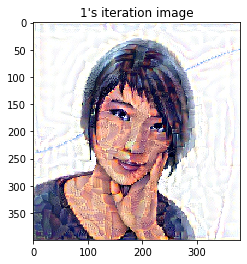

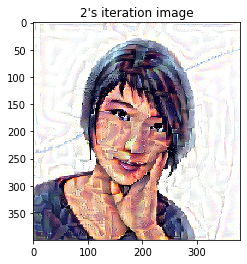

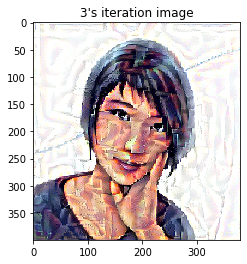

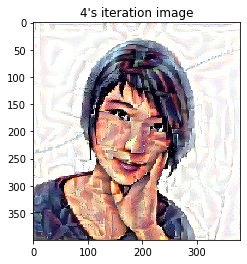

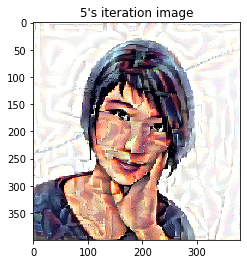

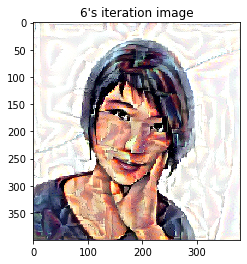

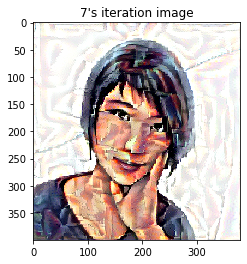

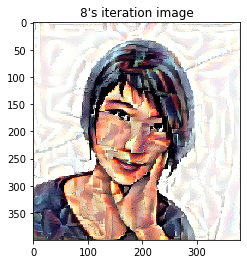

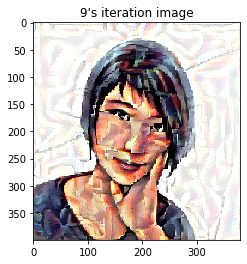

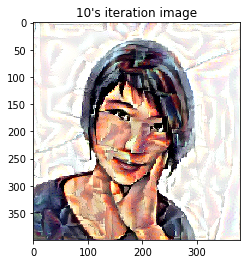

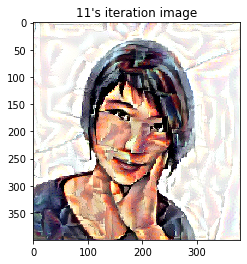

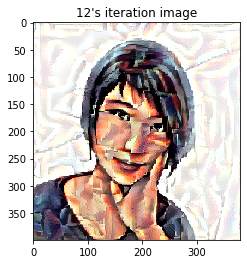

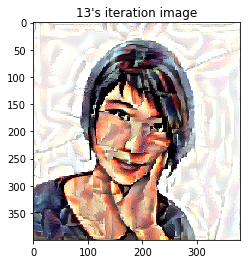

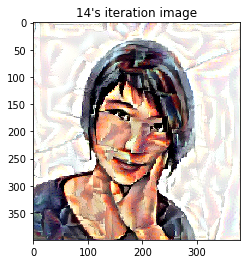

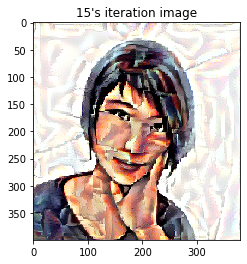

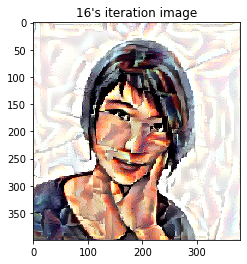

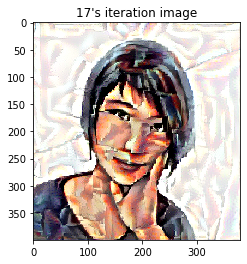

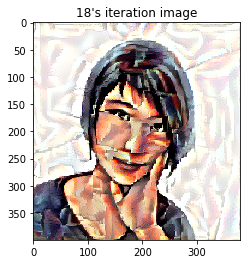

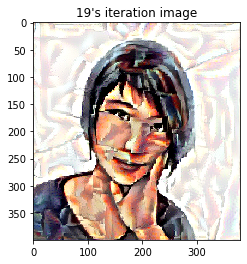

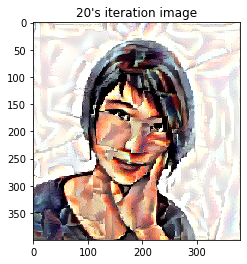

In [17]:
# 결과 이미지 출력

import cv2
import matplotlib.pyplot as plt

for i in range(iteration):
    fname = result_prefix + '_at_iteration_%d.png' % i
    fname = os.path.join('./datasets', fname)

    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.array(img).astype('float32') / 255.
    
    plt.figure()
    plt.title('%d\'s iteration image' % (i+1))
    plt.imshow(img)

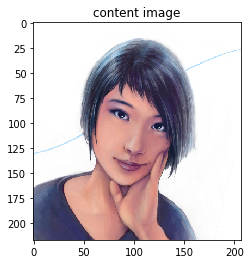

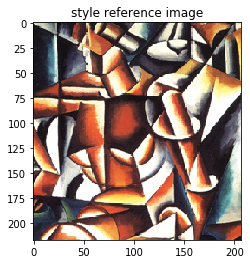

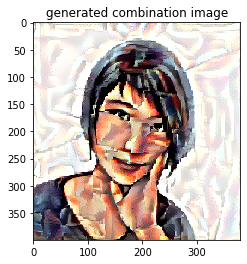

In [22]:
# 콘텐츠 이미지와 스타일 참조 이미지 출력

content_target_fname = './datasets/portrait.png'

img = cv2.imread(content_target_fname)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = np.array(img).astype('float32') / 255.
    
plt.figure()
plt.title('content image')
plt.imshow(img)


style_reference_fname = './datasets/popova.jpg'

img = cv2.imread(style_reference_fname)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = np.array(img).astype('float32') / 255.
    
plt.figure()
plt.title('style reference image')
plt.imshow(img)


generated_fname = './datasets/style_transfer_result_at_iteration_19.png'

img = cv2.imread(generated_fname)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = np.array(img).astype('float32') / 255.
    
plt.figure()
plt.title('generated combination image')
plt.imshow(img)

- 콘텐츠 이미지에 스타일 참조 이미지의 텍스처가 전이되었음

## 8.3.4 정리

- 스타일 트랜스퍼는 타깃 이미지의 콘텐츠는 보존하면서 참조 이미지의 스타일(텍스쳐)을 전이시키는 방법


- 딥러닝에서는 훈련된 컨브넷을 통해 이를 구현할 수 있음
    - 콘텐츠는 convnet의 상위 층 활성화를 사용
    - 스타일은 여러 층의 활성화의 내적(상관관계)를 사용